In [39]:
#imports for the project
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import altair as alt
import csv
import requests
import folium
from folium.plugins import HeatMap

In [40]:
# 21-23 datasets were found at PEN America
df_21_22 = pd.read_csv("datasets/PEN America's Index of School Book Bans (July 1, 2021 - June 30, 2022) - Sorted by Author & Title.csv") #Dataset link: https://docs.google.com/spreadsheets/d/1hTs_PB7KuTMBtNMESFEGuK-0abzhNxVv4tgpI5-iKe8/edit?usp=sharing
df_22_23 = pd.read_csv("datasets/PEN America's Index of School Book Bans (July 1, 2022 - June 30, 2023) - Sorted by Author & Title.csv") #Dataset link: https://docs.google.com/spreadsheets/d/1a6v7R7pidO7TIwRZTIh9T6c0--QNNVufcUUrDcz2GJM/edit?usp=sharing#
# 98-99 datasets were manually constructed
df_98_99 = pd.read_csv("datasets/Copy of challenged_books_1998-99 - Sheet1.csv") # Dataset Link: https://docs.google.com/spreadsheets/d/1xDt6R_AM7eAr7tPkE-NDwOr2sDjIDYbRo8bWpsKvPAc/edit?usp=sharing
df_97_98 = pd.read_csv("datasets/Copy of challenged_books_1997-98 - Sheet1.csv") # Dataset Link: https://docs.google.com/spreadsheets/d/1XbmNW9YRCqiC9852VIb8IBZik0ALvKCi0ykMPW_kC80/edit?gid=0#gid=0
df_genre = pd.read_csv("datasets/books_with_genres.csv")

In [41]:
# the column names were showing up in row one so we replaced the original column names with those
df_21_22 = df_21_22.rename(columns={"Unnamed: 0":"Author", "Unnamed: 1":"Title", "PEN AMERICA'S INDEX OF SCHOOL BOOK BANS":"Ban Status", "Unnamed: 3":"Secondary Author(s)", "Unnamed: 4":"Illustrator(s)", "Unnamed: 5":"Translator(s)", "Unnamed: 6":"State", "Unnamed: 7":"District", "Unnamed: 8":"Date of Challenge/Removal", "Unnamed: 9":"Origin of Challenge"})
df_21_22 = df_21_22.drop(index=0)
df_21_22 = df_21_22.drop(index=1)

In [42]:
# cleaned the state variables to all fllow consistent format
df_97_98.drop("ID", axis=1, inplace=True)
state_abbreviations = {'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KA': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont','VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming'}
df_98_99["State"] = df_98_99["State"].replace(state_abbreviations, inplace=True)
df_97_98["State"] = df_97_98["State"].replace(state_abbreviations, inplace=True)

In [43]:
# the column names were showing up in row one so we replaced the original column names with those
df_22_23 = df_22_23.rename(columns={"Unnamed: 0":"Title", "Unnamed: 1":"Author", "PEN AMERICA'S INDEX OF SCHOOL BOOK BANS":"Secondary Author(s)", "Unnamed: 3":"Illustrator(s)", "Unnamed: 4":"Translator(s)", "Unnamed: 5":"Series Name", "Unnamed: 6":"State", "Unnamed: 7":"District", "Unnamed: 8":"Date of Challenge/Removal", "Unnamed: 9":"Ban Status", "Unnamed: 10":"Origin of Challenge"})
df_22_23 = df_22_23.drop(index=0)
df_22_23 = df_22_23.drop(index=1)
df_22_23 = df_22_23.drop(index=600)

In [44]:
# merged all the data from the 4 datasets together and dropped NaN values in the Author, Title, State and District variables
merged = pd.concat([df_21_22, df_22_23, df_97_98, df_98_99]).sort_values(by="Title").reset_index(drop=True)
merged = merged.dropna(subset=['Author'])
merged = merged.dropna(subset=['Title'])
merged = merged.dropna(subset=['State'])
merged = merged.dropna(subset=['District'])

In [45]:
# function to scrape the web for genre information for the individual books
def get_genre(book_title, book_author):
    url = f'https://openlibrary.org/search.json?title={book_title}&author={book_author}'
    response = requests.get(url)

    # CHAT -- if response is okay, parse to JSON
    if response.status_code == 200: # i'm not sure why it says 200 though?
        data = response.json()
        if 'docs' in data and data['docs']:
            # we'll extract genre (subject) from the API response, default to 'Unknown'

            # Write if statement to check if there is subject facet 
            if 'subject_facet' in data['docs'][0]:
                
                return ','.join(data['docs'][0]['subject_facet'])
            else:
                print("NA")
        else:
            print(f"No results found for '{book_title}' by '{book_author}'")
            
            
    return 'Unknown'

In [46]:
# used the genre information found and added it to the dataset
def add_genres_to_csv(input_file, output_file):
    with open(input_file, mode='r', newline='', encoding='utf-8') as infile, \
         open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Genre']  # add 'Genre' column to the header?
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        
        writer.writeheader()

        for row in reader:
            # If the genre is missing, look up the genre using the book title and author
            if not row.get('Genre'):  # check if genre is missing
                book_title = row.get('Title')  # use the 'New_Book_Title' column
                book_author = row.get('Author')  # Use the 'New_Book_Author' column
                if book_title and book_author:  # gotta make sure the book tilte and author aren't empty
                    genre = get_genre(book_title, book_author)
                    row['Genre'] = genre

                # add the row with the genre to the new CSV
            writer.writerow(row)

In [47]:
# final dataset post-cleaning and webscraping
merged = pd.read_csv('books_with_genres_final.csv')

merged = merged.drop(['Genre1','Genre2','Genre3'], axis=1)

genres_column = 'Genre'

# genre information was split into lists separated by commas, so this code splits the lists up into individual columns
def split_genres(row):
    if not isinstance(row, str):
        return [None] * 6
    genres = row.split(',')
    genres = list(dict.fromkeys(genres))
    first_five = genres[:5]
    # if there are more than 5 genres listed, the remaining genres are put into a final new column
    remaining = genres[5:]
    return first_five + [','.join(remaining) if remaining else None]

# applied the processing function to each row and create new columns
genre_columns = ['Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'remaining_genres']
merged[genre_columns] = merged[genres_column].apply(split_genres).apply(pd.Series)

In [48]:
# merged data by authors to create a dictionary of authors and how many times they appear in the dataset
merged_authors = merged['Author'].astype(str)
merged_authors.head()
formatted_authors = merged_authors.apply(lambda name: " ".join(name.split(", ")[::-1]))
formatted_authors
normalized_authors = formatted_authors.apply(
    lambda name: " ".join(name.split(", ")[::-1]) if ", " in name else name
)

author_frequencies = normalized_authors.value_counts()
author_dict = author_frequencies.to_dict()

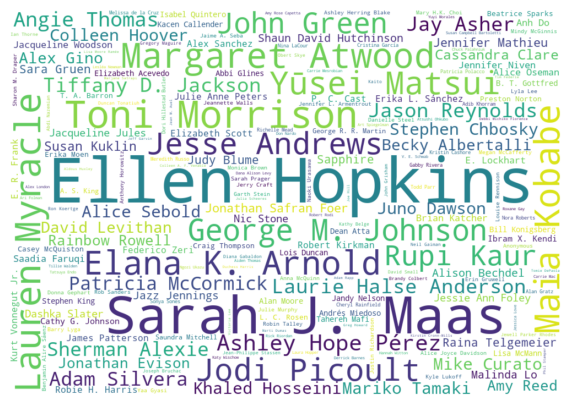

In [49]:
# created frequency word cloud from the author dictionary
words = WordCloud(width=1000, height=700, background_color='white').generate_from_frequencies(author_dict)
plt.figure(figsize=(10,5))
plt.imshow(words, interpolation='bilinear')
plt.axis('off')
plt.show()


In [50]:
# merged data by title to create a dictionary of book titles and how many times they appear in the dataset
merged_title = merged['Title'].astype(str)
title_frequencies = merged_title.value_counts()
title_dict = title_frequencies.to_dict()
title_dict

{'Gender Queer: A Memoir': 67,
 'The Bluest Eye': 51,
 "All Boys Aren't Blue": 48,
 'Out of Darkness': 44,
 'Looking for Alaska': 38,
 'Thirteen Reasons Why': 36,
 'Me and Earl and the Dying Girl': 35,
 'The Hate U Give': 33,
 'The Absolutely True Diary of a Part-Time Indian': 33,
 'The Perks of Being a Wallflower': 33,
 'Tricks': 33,
 'Flamer': 31,
 'Sold': 31,
 'This Book Is Gay': 31,
 'The Kite Runner': 30,
 'Nineteen Minutes': 28,
 'A Court of Mist and Fury': 27,
 'Lawn Boy': 26,
 "The Handmaid's Tale": 25,
 'Beloved': 25,
 'This One Summer': 24,
 'Identical': 24,
 "The Handmaid's Tale: The Graphic Novel": 23,
 'Melissa (George)': 23,
 'Crank': 23,
 'Lucky': 23,
 'Empire of Storms': 22,
 'Milk and Honey': 22,
 'Push': 21,
 'Drama: A Graphic Novel': 21,
 'Water for Elephants': 21,
 'Tilt': 21,
 'Extremely Loud & Incredibly Close': 21,
 'Beyond Magenta: Transgender Teens Speak Out': 20,
 'l8r, g8r': 20,
 "Monday's Not Coming": 20,
 'More Happy Than Not': 20,
 'The Sun and Her Flowers

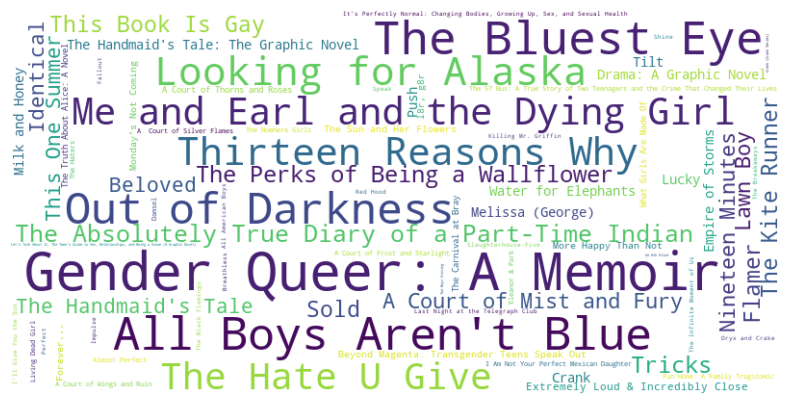

In [51]:
# created frequency word cloud from the title dictionary
words2 = WordCloud(
    width=800,
    height=400,
    background_color='white',
    prefer_horizontal=0.5,
    random_state=42,
).generate_from_frequencies(title_dict)
plt.figure(figsize=(10,5))
plt.imshow(words2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [52]:
# grouped data by title and state to find most banned books in each state
merged = merged[merged['State'].notna()]
state_book_data = merged.groupby(['State', 'Title'], as_index=False).agg(
    BanCount=('State', 'count')
)
most_banned_books = state_book_data.loc[
    state_book_data.groupby('State')['BanCount'].idxmax()
].reset_index(drop=True)
most_banned_books = most_banned_books.drop_duplicates(subset=['State', 'Title'])

most_banned_books = most_banned_books.merge(
    merged[['State', 'Title', 'Author']].drop_duplicates(),
    on=['State', 'Title'],
    how='left'
)

In [53]:
# created chart based on most banned book in each state
states = alt.Chart(most_banned_books).mark_bar().encode(
    x=alt.X('State:N', title='State'),
    y=alt.Y('BanCount:Q', title='Most Banned Book Occurrences'),
    color=alt.Color('Title:N', legend=alt.Legend(title="Most Banned Book")),
    tooltip=['State', 'Title', 'Author', 'BanCount']
).properties(
    width=400,
    height=200,
    title='Most Banned Books by State'
)

# Display the chart
states.configure_title(
    fontSize=16
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).show()

alt.Chart(...)

In [54]:
# groups data by how many times an author has been banned
author_ban_count = book_data.groupby('Author', as_index=False).agg(
    TotalBans=('BanCount', 'sum')
).sort_values(by='TotalBans', ascending=False).head(50)

In [55]:
# from the list of top 50 banned authors, this finds their most banned book
top_authors_books = pd.merge(book_data, author_ban_count[['Author']], on='Author')
top_books = (
    top_authors_books.loc[top_authors_books.groupby('Author')['BanCount'].idxmax()]
    .reset_index(drop=True)
)

In [56]:
# adding number of bans to the authors books
top_books['BookDetails'] = top_books['Title'] + ' (' + top_books['BanCount'].astype(str) + ' bans)'

author_selection = alt.selection_single(fields=['Author'], name="SelectAuthor", empty='all')

# Top 50 Most Banned Authors and their Most Banned Book on hover
bars = alt.Chart(top_books).mark_bar().encode(
    x=alt.X('Author:N', title='Author'),
    y=alt.Y('BanCount:Q', title='Total Ban Count'),
    color=alt.Color('Author:N', legend=alt.Legend(title='Select an Author')),
    opacity=alt.condition(author_selection, alt.value(1), alt.value(0.3)) 
).add_params(
    author_selection
).properties(
    width=600,
    height=300,
    title='Top 50 Most Banned Authors'
)

bars = bars.encode(
    tooltip=[
        alt.Tooltip('Author:N', title='Author'),
        alt.Tooltip('BookDetails:N', title='Most Banned Book'),
        alt.Tooltip('States:N', title='States Banned'),
    ]
)
final_chart = bars
final_chart.show()

/var/folders/69/895q17bx0dq354540c0zkfx40000gn/T/ipykernel_15507/465996030.py:4: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  author_selection = alt.selection_single(fields=['Author'], name="SelectAuthor", empty='all')


alt.Chart(...)

In [57]:
# cleaned up a lot of genre data for values we deemed "not a genre"
merged = merged[merged['Genre1'] != 'Unknown']
merged = merged[merged['Genre1'] != '813/.54']
merged = merged[merged['Genre2'] != '813/.54']
merged = merged[merged['Genre3'] != '813/.54']
merged = merged[merged['Genre1'] != '1000blackgirlbooks']
merged = merged[merged['Genre2'] != '1000blackgirlbooks']
merged = merged[merged['Genre3'] != '1000blackgirlbooks']

In [58]:
# took the data from three genre columns and combined it into one
melter = merged.melt(id_vars=['State'], value_vars=['Genre1', 'Genre2', 'Genre3'],
                        var_name='Genre Column', value_name='Genres')

melter['Genres'] = melter['Genres'].str.strip().str.lower() # lower space check

melter = melter.dropna(subset=['Genres'])

genre_state_counts = melter.groupby(['Genres', 'State']).size().reset_index(name='Count')
max_state_for_genre = genre_state_counts.loc[genre_state_counts.groupby('Genres')['Count'].idxmax()]

counter = melter.groupby('Genres').size().reset_index(name='Total')
counter = counter.merge(max_state_for_genre[['Genres', 'State']], on='Genres')
big_15 = counter.sort_values(by='Total', ascending=False).head(15)

In [59]:
# created interactive chart displaying top 15 most banned genres and the state that bans it the most
chart = alt.Chart(big_15).mark_bar().encode(
    x=alt.X('Genres:N', sort=None),
    y='Total:Q',
    color='Genres:N',
    tooltip=['Genres:N', 'Total:Q', 'State:N'] # cool color setting
).properties(
    width=500,
    height=300,
    title='Top 15 Banned Genres and the states who banned them the most'
)

chart.show()

alt.Chart(...)

In [60]:
Latitude = 'Coordinates'
Longitude = 'Coordinates'
# state coordinates for the U.S. heat map
state_centroids = {
    'Alabama': [32.8066, -86.7913],
    'Alaska': [61.5954, -150.6430],
    'Arizona': [33.7840, -111.9391],
    'Arkansas': [34.7465, -92.2896],
    'California': [36.7783, -119.4179],
    'Colorado': [39.5501, -105.7821],
    'Connecticut': [41.6032, -73.0877],
    'Delaware': [38.9108, -75.5277],
    'Florida': [27.9944, -81.7603],
    'Georgia': [33.7490, -84.3880],
    'Hawaii': [20.2927, -156.3737],
    'Idaho': [44.3509, -114.613],
    'Illinois': [40.0417, -89.1965],
    'Indiana': [39.8942, -86.2816],
    'Iowa': [42.0751, -93.496],
    'Kansas': [38.4937, -98.3804],
    'Kentucky': [37.5347, -85.3021],
    'Louisiana': [31.0689, -91.9968],
    'Maine': [45.3695, -69.2428],
    'Maryland': [39.055, -76.7909],
    'Massachusetts': [42.2596, -71.8083],
    'Michigan': [44.3467, -85.4102],
    'Minnesota': [46.2807, -94.3053],
    'Mississippi': [32.7364, -89.6678],
    'Missouri': [38.3566, -92.458],
    'Montana': [47.0527, -109.6333],
    'Nebraska': [41.5378, -99.7951],
    'Nevada': [39.3289, -116.6312],
    'New Hampshire': [43.6805, -71.5811],
    'New Jersey': [40.1907, -74.6728],
    'New Mexico': [34.4071, -106.1126],
    'New York': [43.0000, -75.0000],
    'North Carolina': [35.7596, -79.0193],
    'North Dakota': [47.5515, -101.0020],
    'Ohio': [40.4173, -82.9071],
    'Oklahoma': [35.4676, -97.5164],
    'Oregon': [43.8041, -120.5542],
    'Pennsylvania': [41.2033, -77.1945],
    'Rhode Island': [41.5801, -71.4774],
    'South Carolina': [33.8361, -81.1637],
    'South Dakota': [44.2998, -99.4388],
    'Tennessee': [35.5175, -86.5804],
    'Texas': [31.9686, -99.9018],
    'Utah': [39.3200, -111.0937],
    'Vermont': [44.5588, -72.5778],
    'Virginia': [37.4316, -78.6569],
    'Washington': [47.7511, -120.7401],
    'West Virginia': [38.5976, -80.4549],
    'Wisconsin': [44.5000, -89.5000],
    'Wyoming': [43.07597, -107.2903]
}

merged['Coordinates'] = merged['State'].map(state_centroids)
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)
# created heat map based on how many bans per state
frequency_data = merged['Coordinates'].value_counts().reset_index(name='Frequency')
frequency_data.columns = ['Coordinates', 'Frequency']

heat_data = [
    [coords[0], coords[1], freq] 
    for coords, freq in zip(frequency_data['Coordinates'], frequency_data['Frequency'])
]

HeatMap(heat_data).add_to(m)
m